Class Weights: {0: 0.42857142857142855, 1: 1.8, 2: 9.0}
Found 33902 images belonging to 3 classes.
Found 152 images belonging to 3 classes.
Epoch 1/10
2118/2118 [==============================] - 414s 192ms/step - loss: 1.5169 - accuracy: 0.5886 - val_loss: 2.3561 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 2/10
2118/2118 [==============================] - 250s 118ms/step - loss: 1.3847 - accuracy: 0.5892 - val_loss: 2.8602 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 3/10
2118/2118 [==============================] - 281s 132ms/step - loss: 1.3745 - accuracy: 0.5892 - val_loss: 2.8952 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 4/10
2118/2118 [==============================] - 251s 118ms/step - loss: 1.3702 - accuracy: 0.5892 - val_loss: 2.7749 - val_accuracy: 0.0972 - lr: 0.0010
Epoch 5/10
2118/2118 [==============================] - 248s 117ms/step - loss: 1.3421 - accuracy: 0.5893 - val_loss: 2.7882 - val_accuracy: 0.1042 - lr: 1.0000e-04
Epoch 6/10
2118/2118 [=============================

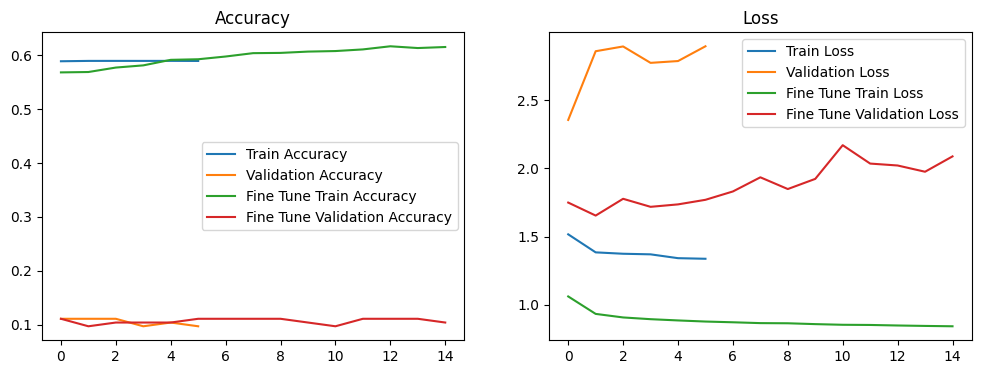

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os
import cv2

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')


# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Hyperparameters
num_classes = 3
BATCH_SIZE = 16
EPOCHS = 10
learning_rate = 0.001
image_size = (160, 160)


# Noise removal function for cleaning dataset
def preprocess_images(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                if os.path.isfile(img_path):
                    # Read and preprocess image
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.GaussianBlur(img, (5, 5), 0)  # Noise reduction
                        img = cv2.resize(img, image_size)  # Resize to match model input
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        cv2.imwrite(img_path, img)  # Overwrite the original image

# Preprocess training and testing datasets
preprocess_images('Train')
preprocess_images('Test_dataset')

# Calculate class weights
train_dir = 'Train'
classes = os.listdir(train_dir)
class_labels = []

for i, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure valid directory
        num_samples = len(os.listdir(class_path))
        class_labels.extend([i] * num_samples)

# Compute class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=np.array(class_labels)
)
class_weights = {i: weights[i] for i in range(len(weights))}
print("Class Weights:", class_weights)

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Define generators
train_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'Test_dataset',
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load base model (EfficientNet)
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax', dtype='float32')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze all but the last 50 layers
    layer.trainable = False
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS + 10,
    initial_epoch=history.epoch[-1],
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Plotting Performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine Tune Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine Tune Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine Tune Train Loss')
plt.plot(history_fine.history['val_loss'], label='Fine Tune Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


1/1 [==============================] - 2s 2s/step


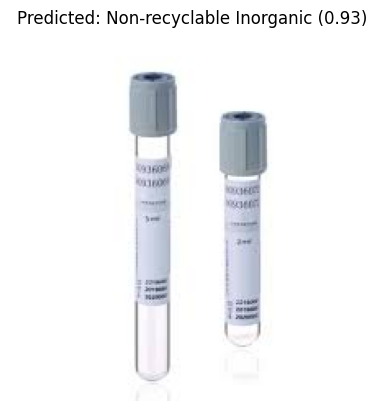

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to a single image for testing
image_path = 'Test_dataset/Non-recyclable inorganic/download (4).jpeg'  # Replace with the actual path to your test image

# Load and preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load the image with target size
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale the image
    return img_array

# Make a prediction
def predict_image(model, image_path, class_names):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)  # Predict probabilities
    predicted_class = np.argmax(predictions, axis=1)  # Get class index
    confidence = np.max(predictions)  # Get confidence score
    return predicted_class[0], confidence

# Class names (update these with your actual class names)
class_names = list(train_generator.class_indices.keys())

# Get prediction and confidence
predicted_class, confidence = predict_image(model, image_path, class_names)

# Display the image and the prediction
img = load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.2f})")
plt.show()


In [2]:
model.save('model_directory')


INFO:tensorflow:Assets written to: model_directory\assets


INFO:tensorflow:Assets written to: model_directory\assets


In [6]:
tf.keras.mixed_precision.set_global_policy('float32')

# Convert the model to TensorFlow Lite with TF Select enabled
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow Select ops.
]
tflite_model = converter.convert()

# Save the model
with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpk2gbwvws\assets


INFO:tensorflow:Assets written to: C:\Users\USER\AppData\Local\Temp\tmpk2gbwvws\assets


: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Enable mixed precision training for performance boost
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Verify GPU is being used
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))

# Set GPU device explicitly (if available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')  # Use the first GPU
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

# Model setup
num_classes = 3
BATCH_SIZE = 32
EPOCHS = 10

# Load base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax', dtype='float32')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    'Test_dataset',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)
    ]
)

# Fine-tuning
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS + 10,
    initial_epoch=history.epoch[-1],
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine Tune Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine Tune Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine Tune Train Loss')
plt.plot(history_fine.history['val_loss'], label='Fine Tune Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is being used")
else:
    print("No GPU found. Using CPU")

GPU is being used


In [2]:
from tensorflow.keras.layers import Layer

# Define your custom layer (if available)
class GaussianNoiseLayer(Layer):
    def __init__(self, stddev=0.1, **kwargs):
        super(GaussianNoiseLayer, self).__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            return inputs + tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
        return inputs

# Load Keras model
def load_model():
    try:
        model = tf.keras.models.load_model("final_robust_model.h5", custom_objects={"GaussianNoiseLayer": GaussianNoiseLayer})
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
